In [16]:
!apt-get update
!apt-get install -y stockfish
!pip install chess
import chess
import chess.engine
from IPython.display import clear_output
import sys
import re
import matplotlib.pyplot as plt
import numpy as np # Nécessaire pour l'échelle symlog
clear_output()


In [20]:
# banque de parties

# Shredder Agrresive - Vincent / 15 11 2025 / 0-1 / 1995 - ~1800 / Sceaux
moves_str = "1.e2-e4 c7-c5 2.Ng1-f3 Nb8-c6 3.d2-d4 d7-d6 4.d4-d5 Nc6-e5 5.Nf3xe5 d6xe5 6.Bf1-b5+ Bc8-d7 7.Bb5xd7+ Qd8xd7 8.Nb1-c3 e7-e6 9.0-0 e6xd5 10.Nc3xd5 Ng8-e7 11.c2-c4 Ne7xd5 12.c4xd5 Bf8-d6 13.Bc1-g5 0-0 14.Qd1-e2 Ra8-c8 15.Ra1-c1 b7-b5 16.b2-b3 a7-a5 17.f2-f3 Rc8-c7 18.Qe2-d2 Rf8-a8 19.Qd2-e2 f7-f6 20.Bg5-e3 a5-a4 21.Qe2-f2 a4xb3 22.a2xb3 c5-c4 23.b3xc4 b5xc4 24.Be3-b6 Rc7-c8 25.Rc1-c2 Ra8-b8 26.Rf1-c1 Qd7-b5 27.Rc2-b2 Qb5-a6 28.Bb6-e3 Rb8xb2 29.Qf2xb2 Rc8-b8 30.Rc1-a1 Qa6-c8 31.Qb2-c3 Rb8-b3 32.Qc3-c1 Bd6-b4 33.Kg1-h1 c4-c3 34.Ra1-a2 Qc8-c4 35.Ra2-a8+ Kg8-f7 36.h2-h3 Qc4-d3 37.Ra8-a7+ Kf7-f8 38.Ra7-a8+ Kf8-f7 39.Ra8-a7+ Kf7-f8 40.Qc1-g1 Rb3-b1 41.Ra7-a8+ Kf8-f7 42.Ra8-a7+ Kf7-g6 43.Be3-c1 c3-c2 44.h3-h4 Qd3-d1 45.h4-h5+ Kg6xh5 46.g2-g4+ Kh5-g6 47.Kh1-g2 Qd1xg1+ 48.Kg2xg1 Rb1xc1+ 49.Kg1-h2"

# mettre ci dessus le copié collé de la partie Shredder / iphone

In [21]:
#Dans le match à Analyser : (data will be put into the final graph...)
PW = "Shredder Agressive" # white player 'like : "Karpov, A",
PWELO = "1995"            # white player Elo : "2735"
PB = "Vincent Pinte Deregnaucourt" # black player 'like : "Kasparov, G",
PBELO  = "No Licence ~1800 ?" # black player Elo : "2735"
SCOREMATCH = "0-1"       # "1-0", "draw", ... (it is a string )
DATE_GAME = "2025/11/15"        # "2012/12/12" or "Last day of my life..."
TOURNMT = "Sceaux"          # "Wijk an See", "", "home !", "Computer".
ROUND = "*"            # "" or "12", or "Twelve", or "unknown"

#### ********************************** Temps d'analyse ici ***********************
# temps d'analyse par coup :
X_secondes = 5 # 5 = 5 secondes par coup
##########@##########@##########@##########@##########@##########@##########@######

print(f"temps d'analyse demandé : {X_secondes} seconde(s) par coup)")

temps d'analyse demandé : 5 seconde(s) par coup)


Moteur Stockfish trouvé à : /usr/games/stockfish
Début de l'analyse (Temps par coup : 5s)...
1. e2e4                               [+53]                                          c7c5                               [+56]                                        
2. g1f3                               [+50]                                          b8c6                               [+36]                                        
3. d2d4      (best: f1b5)             [+50]                                          d7d6      (best: c5d4)             [+175]                                       
4. d4d5                               [+184]                                         c6e5      (best: c6b8)             [+291]                                       
5. f3e5                               [+292]                                         d6e5                               [+267]                                       
6. f1b5      (best: d1h5)             [+208]                                 

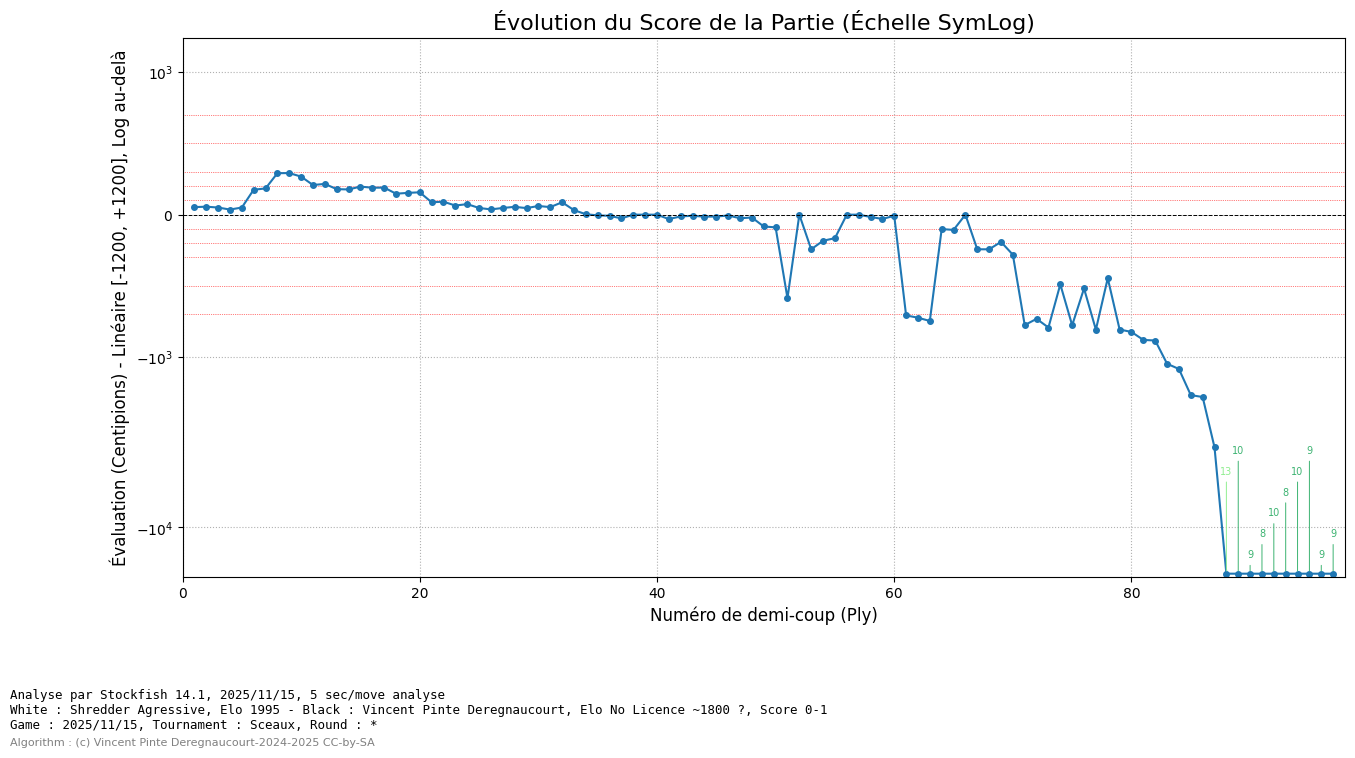

In [22]:
engine_paths = ["/usr/games/stockfish", "/usr/bin/stockfish", "stockfish"]
engine_path = None
for path in engine_paths:
    try:
        with chess.engine.SimpleEngine.popen_uci(path) as test_engine:
            pass
        engine_path = path
        break
    except FileNotFoundError:
        continue

if engine_path is None:
    print("Erreur: Moteur Stockfish introuvable.")
    sys.exit(1)

print(f"Moteur Stockfish trouvé à : {engine_path}")
print(f"Début de l'analyse (Temps par coup : {X_secondes}s)...")

# --- Logique d'analyse ---
moves_list = moves_str.split()
board = chess.Board()
engine = chess.engine.SimpleEngine.popen_uci(engine_path)
# --- Récupération de la version IMMÉDIATEMENT ---
try:
    engine_id = engine.id              # ne pas appeler ça après quit()
    full_name = engine_id.get("name", "Stockfish")
    m = re.search(r"\d+(\.\d+)?", full_name)
    major = m.group(0) if m else "?"
    stockfish_version = full_name      # ex: "Stockfish 16.1"
    stockfish_major = major            # ex: "16.1"
except Exception as e:
    stockfish_version = f"Version inconnue ({e})"
    stockfish_major = None
# return engine, stockfish_version, stockfish_major

scores_for_plot = []
mate_sequences = {}
ply_count = 0
full_move_number = 1
last_engine_best_move_uci = None

COL_UCI = 10
COL_BEST = 25
COL_SCORE = 45

white_move_components = None

for token in moves_list:

    # --- Parsing (inchangé) ---
    if '.' in token:
        num, move_part = token.split('.', 1)
        move = move_part
    else:
        move = token
    move = move.strip('+').strip('#')

    if move == '0-0' or move == 'O-O':
        if board.turn == chess.WHITE: uci = 'e1g1'
        else: uci = 'e8g8'
    elif move == '0-0-0' or move == 'O-O-O':
        if board.turn == chess.WHITE: uci = 'e1c1'
        else: uci = 'e8c8'
    else:
        if 'x' in move: sep = 'x'
        else: sep = '-'
        parts = move.split(sep, 1)
        from_part = parts[0]
        to_part = parts[1]
        if len(from_part) > 2: from_sq = from_part[1:]
        else: from_sq = from_part
        promo = ''
        if len(to_part) > 2:
            to_sq = to_part[:2]
            promo = to_part[2].lower()
        else: to_sq = to_part
        uci = from_sq + to_sq + promo

    played_uci = uci
    played_uci_str = played_uci
    best_move_str = ""

    if last_engine_best_move_uci and played_uci != last_engine_best_move_uci:
        best_move_str = f"(best: {last_engine_best_move_uci})"

    try:
        chess_move = chess.Move.from_uci(played_uci)
        board.push(chess_move)
    except Exception:
        # Logique de correction de mouvement inversé ou autre (inchangée)
        try:
            if promo == '':
                uci_reverse = to_sq + from_sq + promo
                chess_move = chess.Move.from_uci(uci_reverse)
                board.push(chess_move)
                played_uci = uci_reverse

                played_uci_str = played_uci
                best_move_str = ""
                if last_engine_best_move_uci and played_uci != last_engine_best_move_uci:
                    best_move_str = f"(meilleur: {last_engine_best_move_uci})"
            else:
                raise
        except Exception as e:
            print(f"\nErreur fatale au coup : {token} (tentative UCI: {played_uci})")
            print(f"Board FEN: {board.fen()} | Erreur: {e}")
            break

    ply_count += 1
    is_white_move_just_played = (board.turn == chess.BLACK)

    # Déterminer la couleur du coup joué pour la référence de mat
    color_ref = "White" if is_white_move_just_played else "Black"

    # --- Bloc d'analyse robuste ---
    score = None
    last_engine_best_move_uci = None
    score_str = "[Erreur]"
    mate_in = None

    try:
        info = engine.analyse(board, chess.engine.Limit(time=X_secondes))
        score = info["score"].white()
        best_move_obj = info.get('pv', [None])[0]
        last_engine_best_move_uci = best_move_obj.uci() if best_move_obj else None

        score_str = f"[{score}]"

        # --- MODIFIÉ : Gestion et Stockage du Mat ---
        if score.is_mate():
            mate_in = score.mate()

            # 1. Préparer la clé de référence (ex: "69-White")
            mate_key = f"{full_move_number}-{color_ref}"

            # 2. Construire la séquence de mat (pour le stockage)
            mate_sequence_str = ""
            pv = info.get('pv')
            if pv:
                temp_board = board.copy()
                mate_moves_san = []
                try:
                    for move in pv:
                        if temp_board.is_legal(move):
                            mate_moves_san.append(temp_board.san(move))
                            temp_board.push(move)
                        else:
                            break
                    mate_sequence_str = ' '.join(mate_moves_san)
                except Exception as e_mate:
                    mate_sequence_str = "(Erreur lors de la génération de la séquence SAN)"

            # 3. Stocker dans le dictionnaire
            mate_sequences[mate_key] = {
                'score_str': str(score),
                'sequence': mate_sequence_str
            }

            # 4. MODIFIER score_str pour utiliser la référence
            score_str += f" (cf {mate_key})"

    except Exception as e:
        # Gestion d'erreur (inchangée)
        print(f"--- Erreur d'analyse au coup {ply_count} ({played_uci}) ---")
        print(f"    Erreur: {e}")
        print(f"    FEN: {board.fen()}")
        print(f"-------------------------------------------------")
        # mate_in reste None

    # --- Stockage pour le Graphique (inchangé) ---
    score_val = 0
    mate_to_plot = None

    if score:
        score_val = score.score(mate_score=20000)
        if score_val is None:
            score_val = 0
        mate_to_plot = mate_in

    scores_for_plot.append((ply_count, score_val, mate_to_plot))

    # --- A) Assemblage final pour l'affichage ---
    move_components = (played_uci_str, best_move_str, score_str)

    if is_white_move_just_played:
        white_move_components = move_components
    else:
        w_uci, w_best, w_score = white_move_components
        b_uci, b_best, b_score = move_components

        white_part = f"{w_uci:<{COL_UCI}}{w_best:<{COL_BEST}}{w_score:<{COL_SCORE}}"
        black_part = f"{b_uci:<{COL_UCI}}{b_best:<{COL_BEST}}{b_score:<{COL_SCORE}}"

        print(f"{full_move_number}. {white_part}  {black_part}")

        full_move_number += 1
        white_move_components = None

if white_move_components:
    w_uci, w_best, w_score = white_move_components
    white_part = f"{w_uci:<{COL_UCI}}{w_best:<{COL_BEST}}{w_score:<{COL_SCORE}}"
    print(f"{full_move_number}. {white_part}")

engine.quit()
print("\nAnalyse terminée.")

# --- Affichage structuré des séquences de mat ---
if mate_sequences:
    print("\n" + "="*50)
    print("📋 Séquences de Mat Détaillées")
    print("="*50)

    # Trier les clés de référence (ex: "69-White", "69-Black", "70-White", etc.)
    sorted_keys = sorted(mate_sequences.keys(), key=lambda x: (int(x.split('-')[0]), x.split('-')[1]))

    for key in sorted_keys:
        details = mate_sequences[key]
        print(f"{key}, {details['score_str']}: Mat via: {details['sequence']}")
else:
    print("\nAucune séquence de mat n'a été trouvée durant l'analyse.")

# --- FIN DU CODE

print("\nAnalyse terminée.")

# --- Génération du Graphique -------------------------------------------------------------------------------------
print("Génération du graphique...")


# (m dans votre description) Détermine le cycle de hauteur d'empilement basé sur le numéro de ply.
MATE_STACK_MODULO = 6
PIXEL_OFFSET_STEP = 15 # Décalage vertical minimum en pixels (beta)

if scores_for_plot:
    # Décompression des 3 listes
    ply_numbers, plot_scores, mate_data = zip(*scores_for_plot)

    plt.figure(figsize=(15, 7))
    plt.plot(ply_numbers, plot_scores, marker='o', linestyle='-', markersize=4, label="Évaluation")
    plt.axhline(0, color='black', linewidth=0.7, linestyle='--')

    # Lignes de grille personnalisées
    grid_lines = [-700, -500, -300, -200, -100, 100, 200, 300, 500, 700]
    for y_val in grid_lines:
        plt.axhline(y_val, color='red', linestyle=':', linewidth=0.5, zorder=0)

    # B) Échelle "SymLog"
    plt.yscale('symlog', linthresh=1200)

    plt.xlim(0, len(ply_numbers) + 1)

    # --- Logique de Mat Annotation ---
    for i in range(len(ply_numbers)):
        mate_val_signed = mate_data[i] # Contient +N, -N, ou None

        if mate_val_signed is not None:
            ply = ply_numbers[i]
            score_val = plot_scores[i]
            mate_in_abs = abs(mate_val_signed) # N, le nombre de coups pour le mat

            # --- 1. Définition de la Couleur (Critères d'urgence) ---
            if 0 <= mate_in_abs <= 5:
                mate_color = 'darkgreen'
            elif 6 <= mate_in_abs <= 10:
                mate_color = 'mediumseagreen'
            else: # 11 et plus
                mate_color = 'lightgreen'

            # --- 2. Logique d'Empilement (basée sur le numéro de ply) ---
            # Utilise le numéro de demi-coup (ply) modulo MATE_STACK_MODULO
            stack_level = ply % MATE_STACK_MODULO

            # Décalage vertical de base (pour le texte)
            base_offset_pixels = 10

            # Calcule le décalage final
            final_offset_pixels = base_offset_pixels + (stack_level * PIXEL_OFFSET_STEP)

            # --- 3. Annotation ---
            plt.annotate(
                f"{mate_in_abs}",          # Afficher seulement la valeur (ex: 13)
                (ply, score_val),          # Le point (x,y) à annoter
                xytext=(0, final_offset_pixels),
                textcoords='offset points',
                color=mate_color,          # Utiliser la couleur dynamique
                ha='center',
                va='bottom',               # Texte toujours au-dessus du point de référence
                fontsize=7,                # Taille de police plus petite
                # L'arrowprops pour la ligne verticale plus fine et sans gras
                arrowprops=dict(arrowstyle='-', color=mate_color, lw=0.7)
            )


    plt.title("Évolution du Score de la Partie (Échelle SymLog)", fontsize=16)
    plt.xlabel("Numéro de demi-coup (Ply)", fontsize=12)
    plt.ylabel("Évaluation (Centipions) - Linéaire [-1200, +1200], Log au-delà", fontsize=12)

    plt.grid(True, linestyle=':')

    print(f"Analyse par {stockfish_version}, Engine : {engine}, Stkfh Major : {stockfish_major}")

    # --- NOUVEAU : Création du bloc d'information à gauche ---
    info_text_line1 = f"Analyse par {stockfish_version}, {DATE_GAME}, {X_secondes} sec/move analyse"
    info_text_line2 = f"White : {PW}, Elo {PWELO} - Black : {PB}, Elo {PBELO}, Score {SCOREMATCH}"
    info_text_line3 = f"Game : {DATE_GAME}, Tournament : {TOURNMT}, Round : {ROUND}"

    full_info_text = f"{info_text_line1}\n{info_text_line2}\n{info_text_line3}"

    # Placement de l'information du jeu/analyse (en bas à gauche)
    # x=0.01, y=-0.08 sont des coordonnées normalisées de la figure (0,0 est le coin inf. gauche)
    plt.figtext(0.01, -0.05, full_info_text,
                fontsize=9, ha='left', va='top', family='monospace')

    # --- NOUVEAU : Ajout de la licence/du droit d'auteur (toujours visible) ---
    copyright_text = "Algorithm : (c) Vincent Pinte Deregnaucourt-2024-2025 CC-by-SA"
    # Placement du droit d'auteur (juste au-dessus du bloc d'info)
    plt.figtext(0.01, -0.12, copyright_text,
                fontsize=8, ha='left', va='top', color='gray')

    print("Affichage du graphique. Fermez la fenêtre du graphique pour quitter.")
    plt.show()
else:
    print("Aucune donnée d'analyse n'a été collectée pour le graphique.")